# Bond Mechanics 202
<p style="color:darkblue; "><b>A TurningBull Notebook</b>

This notebook provides an advanced tutorial on bond yields and mechanics using Python examples. We'll explore U.S. Treasury bond pricing conventions, the relationship between bond prices and yields, and how to calculate total returns over various holding periods.

**Topics covered:**
1. U.S. Treasury Bond pricing conventions (1/32s pricing, premium vs discount bonds, clean vs dirty prices)
2. Bond price-yield relationship and different yield measures (nominal, current, yield to maturity)
3. Total return calculation for bonds held over various periods

Throughout this notebook, we'll use matplotlib to create visualizations that illustrate key concepts.

## Pricing a 4.5% Coupon Bond Using Spot Rates

In this section, we'll demonstrate how to price a 10-year, 4.5% coupon bond using a set of spot rates. The spot rates are loaded from the file `var/jun2025/spot_rates.json`. Each spot rate represents the yield for a zero-coupon bond maturing in that year. We'll discount each cash flow of the bond using the corresponding spot rate to find the present value (price) of the bond.

**Key steps:**
- Load spot rates from the JSON file
- Calculate the present value of each coupon and principal payment
- Sum the present values to get the bond price


In [16]:
import json
import numpy as np
import pandas as pd
# Load spot rates from JSON file

spot_rates = pd.read_json("../var/jun2025/spot_rates.json").set_index("xt")["spot_rate"].div(100).astype(float).tolist()[3:]

# Bond parameters
par_value = 100
coupon_rate = 0.05
years = 10
frequency = 2  # semiannual coupons
periods = years * frequency

# Prepare cash flows (semiannual)
coupon_payment = par_value * coupon_rate / frequency
cash_flows = [coupon_payment] * (periods - 1) + [coupon_payment + par_value]

# Discount each cash flow using the corresponding spot rate (convert to per-period)
def present_value(cf, r, t):
    return cf / (1 + r / frequency) ** t

pv_total = 0
for t, cf in enumerate(cash_flows, 1):
    spot = spot_rates[t - 1]  # Use the spot rate for the current period
    pv = present_value(cf, spot, t)
    pv_total += pv
    print(f"Period {t}: Cash Flow = ${cf:.2f}, Spot Rate = {spot*100:.3f}%, PV = ${pv:.2f}")

print(f"\nBond Price (using spot rates, semiannual): ${pv_total:.2f}")

Period 1: Cash Flow = $2.50, Spot Rate = 4.290%, PV = $2.45
Period 2: Cash Flow = $2.50, Spot Rate = 4.017%, PV = $2.40
Period 3: Cash Flow = $2.50, Spot Rate = 3.846%, PV = $2.36
Period 4: Cash Flow = $2.50, Spot Rate = 3.811%, PV = $2.32
Period 5: Cash Flow = $2.50, Spot Rate = 3.794%, PV = $2.28
Period 6: Cash Flow = $2.50, Spot Rate = 3.781%, PV = $2.23
Period 7: Cash Flow = $2.50, Spot Rate = 3.785%, PV = $2.19
Period 8: Cash Flow = $2.50, Spot Rate = 3.805%, PV = $2.15
Period 9: Cash Flow = $2.50, Spot Rate = 3.838%, PV = $2.11
Period 10: Cash Flow = $2.50, Spot Rate = 3.881%, PV = $2.06
Period 11: Cash Flow = $2.50, Spot Rate = 3.931%, PV = $2.02
Period 12: Cash Flow = $2.50, Spot Rate = 3.986%, PV = $1.97
Period 13: Cash Flow = $2.50, Spot Rate = 4.041%, PV = $1.93
Period 14: Cash Flow = $2.50, Spot Rate = 4.096%, PV = $1.88
Period 15: Cash Flow = $2.50, Spot Rate = 4.147%, PV = $1.84
Period 16: Cash Flow = $2.50, Spot Rate = 4.194%, PV = $1.79
Period 17: Cash Flow = $2.50, Spo

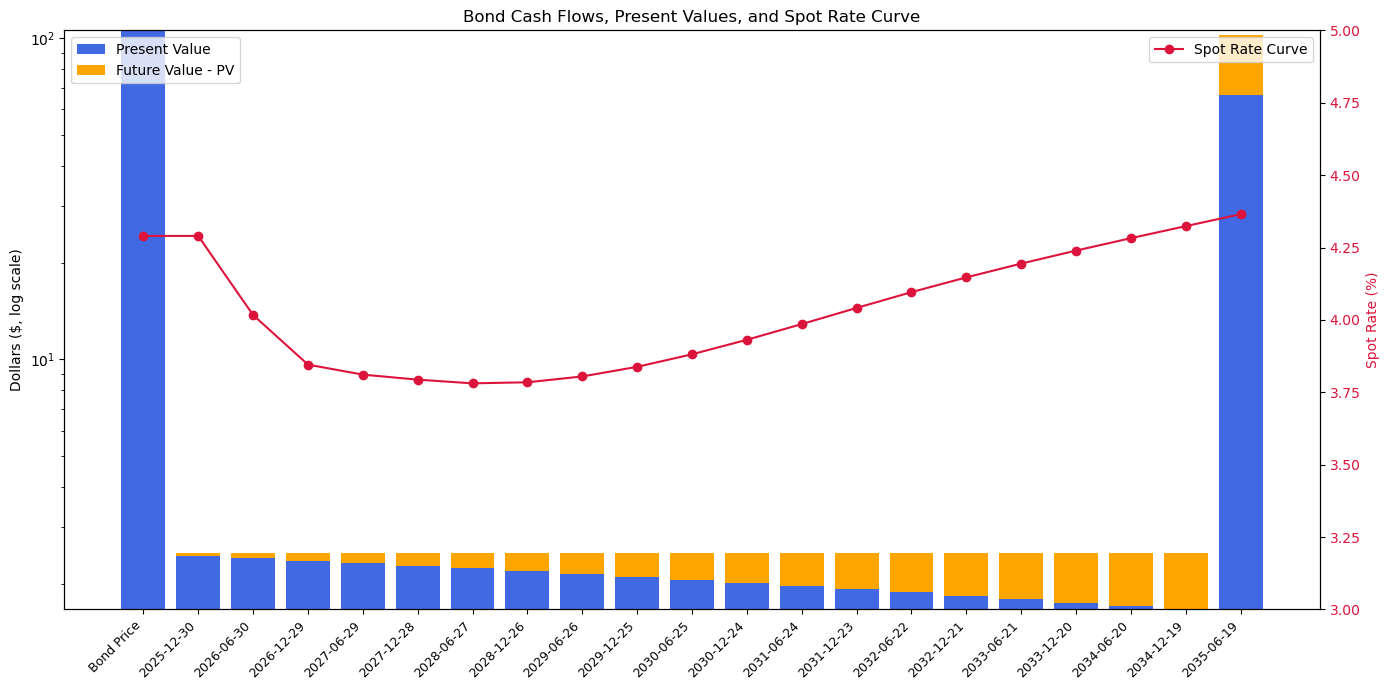

In [21]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

# --- Chart: Stacked bar of cash flows and PVs ---
# Assume settlement date is today for illustration
settlement_date = datetime.today()
dates = [settlement_date + timedelta(days=182*t) for t in range(1, periods+1)]
date_labels = [d.strftime('%Y-%m-%d') for d in dates]

# Calculate PVs and differences for each cash flow
pv_list = []
diff_list = []
for t, cf in enumerate(cash_flows, 1):
    spot = spot_rates[t - 1]
    pv = present_value(cf, spot, t)
    pv_list.append(pv)
    diff_list.append(cf - pv)

# Insert left-most bar: total PV (bond price)
bar_labels = ['Bond Price'] + date_labels
pv_bars = [sum(pv_list)] + pv_list
diff_bars = [0] + diff_list  # No diff for total PV

fig, ax1 = plt.subplots(figsize=(14, 7))
x = range(len(bar_labels))
bars1 = ax1.bar(x, pv_bars, label='Present Value', color='royalblue')
bars2 = ax1.bar(x, diff_bars, bottom=pv_bars, label='Future Value - PV', color='orange')

ax1.set_xticks(x)
ax1.set_xticklabels(bar_labels, rotation=45, ha='right', fontsize=9)
ax1.set_yscale('log')
ax1.set_ylabel('Dollars ($, log scale)')
ax1.set_title('Bond Cash Flows, Present Values, and Spot Rate Curve')
ax1.legend(loc='upper left')

# Add spot rate curve on secondary y-axis, aligned with bars
ax2 = ax1.twinx()
spot_curve = [spot_rates[0]*100] + [spot_rates[i-1]*100 for i in range(1, len(bar_labels))]
ax2.plot(x, spot_curve, color='crimson', marker='o', label='Spot Rate Curve')
ax2.set_ylabel('Spot Rate (%)', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')
ax2.set_ylim(3, 5)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [22]:
## Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import newton
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. U.S. Treasury Bond Pricing Conventions

U.S. Treasury bonds are quoted in a unique format that differs from corporate bonds. Understanding these conventions is crucial for bond analysis.

### 1.1 Converting Quoted Prices from 1/32s to Dollar Amounts

Treasury bonds are quoted in points and 32nds of a point. For example, a quote of "101-16" means 101 and 16/32 points, which equals 101.50% of par value.

In [23]:
def convert_treasury_quote(quote_str, par_value=1000):
    """
    Convert Treasury bond quote from 1/32s format to dollar price
    
    Parameters:
    quote_str: string in format "XXX-YY" where XXX is points and YY is 32nds
    par_value: face value of the bond (default $1000)
    
    Returns:
    Dollar price of the bond
    """
    if '-' in quote_str:
        points, thirty_seconds = quote_str.split('-')
        points = float(points)
        thirty_seconds = float(thirty_seconds)
    else:
        points = float(quote_str)
        thirty_seconds = 0
    
    # Convert to percentage
    percentage = points + (thirty_seconds / 32)
    
    # Convert to dollar amount
    dollar_price = (percentage / 100) * par_value
    
    return dollar_price, percentage

# Examples of Treasury quote conversions
quotes = ["100-00", "101-16", "99-24", "102-08", "98-12"]
print("Treasury Bond Quote Conversions:")
print("Quote\t\tDollar Price\tPercentage")
print("-" * 45)

for quote in quotes:
    dollar_price, percentage = convert_treasury_quote(quote)
    print(f"{quote}\t\t${dollar_price:.2f}\t\t{percentage:.3f}%")

Treasury Bond Quote Conversions:
Quote		Dollar Price	Percentage
---------------------------------------------
100-00		$1000.00		100.000%
101-16		$1015.00		101.500%
99-24		$997.50		99.750%
102-08		$1022.50		102.250%
98-12		$983.75		98.375%


### 1.2 Premium vs. Discount Bonds

- **Premium Bond**: Trades above par value (> 100% of face value)
- **Discount Bond**: Trades below par value (< 100% of face value)  
- **Par Bond**: Trades at face value (= 100% of face value)

The relationship between coupon rate and prevailing interest rates determines whether a bond trades at premium, discount, or par.

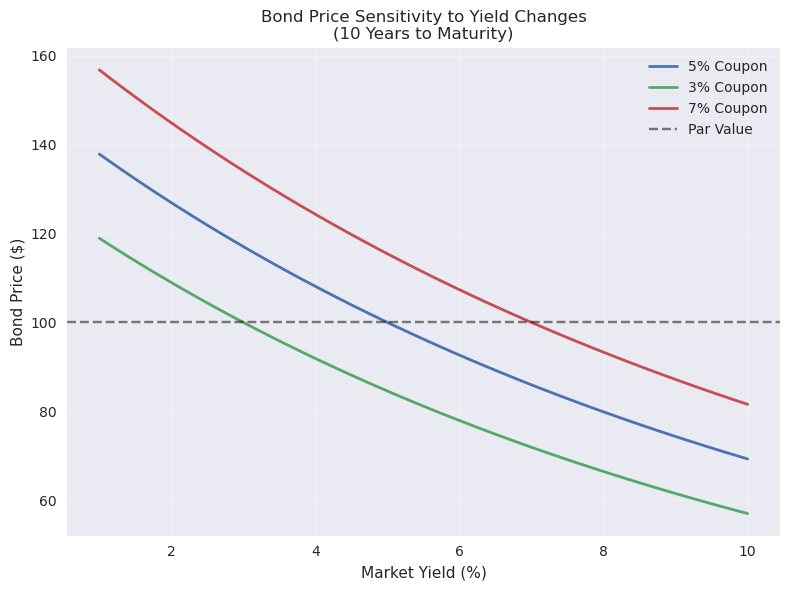

In [24]:
# Only plot: Price sensitivity to yield changes
fig, ax = plt.subplots(figsize=(8, 6))

# Bond characteristics
def bond_price(coupon_rate, yield_rate, years, par=100):
    """Calculate bond price using present value formula"""
    coupon = coupon_rate * par / 100
    pv_coupons = sum([coupon / (1 + yield_rate/100)**t for t in range(1, years+1)])
    pv_principal = par / (1 + yield_rate/100)**years
    return pv_coupons + pv_principal

years_to_maturity = 10
yields = np.linspace(1, 10, 50)
prices_5pct = [bond_price(5, y, years_to_maturity) for y in yields]
prices_3pct = [bond_price(3, y, years_to_maturity) for y in yields]
prices_7pct = [bond_price(7, y, years_to_maturity) for y in yields]

ax.plot(yields, prices_5pct, label='5% Coupon', linewidth=2)
ax.plot(yields, prices_3pct, label='3% Coupon', linewidth=2)
ax.plot(yields, prices_7pct, label='7% Coupon', linewidth=2)
ax.axhline(y=100, color='black', linestyle='--', alpha=0.5, label='Par Value')
ax.set_xlabel('Market Yield (%)')
ax.set_ylabel('Bond Price ($)')
ax.set_title('Bond Price Sensitivity to Yield Changes\n(10 Years to Maturity)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

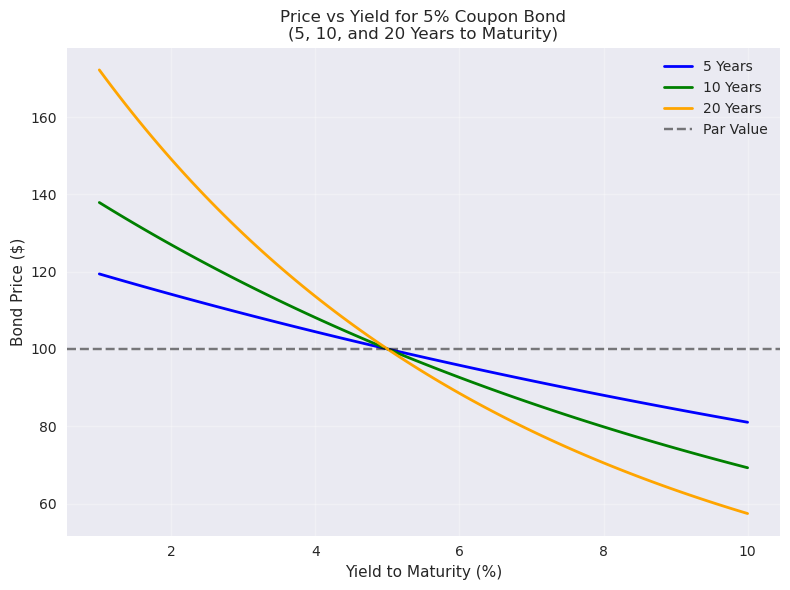

In [15]:
# Price vs Yield for a 5% Coupon Bond at 5, 10, and 20 Years to Maturity
fig, ax = plt.subplots(figsize=(8, 6))

yields = np.linspace(1, 10, 100)
par = 100
coupon_rate = 5
maturities = [5, 10, 20]
colors = ['blue', 'green', 'orange']
labels = [f'{n} Years' for n in maturities]

for n, color, label in zip(maturities, colors, labels):
    prices = [bond_price(coupon_rate, y, n, par) for y in yields]
    ax.plot(yields, prices, label=label, color=color, linewidth=2)

ax.axhline(y=par, color='black', linestyle='--', alpha=0.5, label='Par Value')
ax.set_xlabel('Yield to Maturity (%)')
ax.set_ylabel('Bond Price ($)')
ax.set_title('Price vs Yield for 5% Coupon Bond\n(5, 10, and 20 Years to Maturity)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.3 Clean vs. Dirty Price and Accrued Interest

- **Clean Price**: The quoted price of a bond, excluding accrued interest
- **Dirty Price**: The actual price paid, including accrued interest
- **Accrued Interest**: Interest earned since the last coupon payment

**Formula**: Dirty Price = Clean Price + Accrued Interest

Bond Pricing Example:
Coupon Rate: 4.5%
Par Value: $1,000.00
Clean Price: 102.25% = $1,022.50
Days since last coupon: 145
Days in coupon period: 182

Accrued Interest: $17.93
Dirty Price: $1,022.50 + $17.93 = $1,040.43


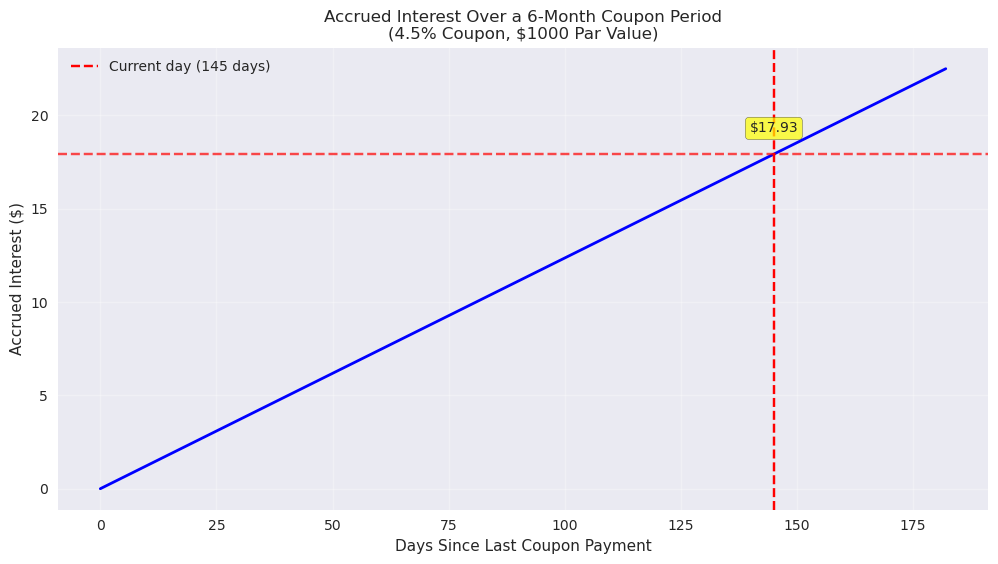

In [9]:
def calculate_accrued_interest(coupon_rate, par_value, days_since_last_coupon, days_in_period, frequency=2):
    """
    Calculate accrued interest for a bond
    
    Parameters:
    coupon_rate: annual coupon rate (as percentage)
    par_value: face value of bond
    days_since_last_coupon: days since last coupon payment
    days_in_period: total days in coupon period
    frequency: coupon payments per year (default 2 for semi-annual)
    """
    annual_coupon = (coupon_rate / 100) * par_value
    period_coupon = annual_coupon / frequency
    accrued = period_coupon * (days_since_last_coupon / days_in_period)
    return accrued

# Example calculation
bond_params = {
    'coupon_rate': 4.5,
    'par_value': 1000,
    'clean_price': 102.25,  # as percentage of par
    'days_since_last_coupon': 145,
    'days_in_period': 182  # approximately 6 months
}

accrued_interest = calculate_accrued_interest(
    bond_params['coupon_rate'],
    bond_params['par_value'],
    bond_params['days_since_last_coupon'],
    bond_params['days_in_period']
)

clean_price_dollar = (bond_params['clean_price'] / 100) * bond_params['par_value']
dirty_price = clean_price_dollar + accrued_interest

print("Bond Pricing Example:")
print(f"Coupon Rate: {bond_params['coupon_rate']}%")
print(f"Par Value: ${bond_params['par_value']:,.2f}")
print(f"Clean Price: {bond_params['clean_price']}% = ${clean_price_dollar:,.2f}")
print(f"Days since last coupon: {bond_params['days_since_last_coupon']}")
print(f"Days in coupon period: {bond_params['days_in_period']}")
print(f"\nAccrued Interest: ${accrued_interest:.2f}")
print(f"Dirty Price: ${clean_price_dollar:,.2f} + ${accrued_interest:.2f} = ${dirty_price:,.2f}")

# Visualize accrued interest over a coupon period
days = np.arange(0, 183, 1)  # 6-month period
accrued_daily = [calculate_accrued_interest(4.5, 1000, day, 182) for day in days]

plt.figure(figsize=(12, 6))
plt.plot(days, accrued_daily, linewidth=2, color='blue')
plt.axvline(x=145, color='red', linestyle='--', label=f'Current day ({bond_params["days_since_last_coupon"]} days)')
plt.axhline(y=accrued_interest, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Days Since Last Coupon Payment')
plt.ylabel('Accrued Interest ($)')
plt.title('Accrued Interest Over a 6-Month Coupon Period\n(4.5% Coupon, $1000 Par Value)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.text(145, accrued_interest + 1, f'${accrued_interest:.2f}', ha='center', va='bottom', 
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
plt.show()

## 2. Bond Price-Yield Relationship and Yield Measures

There are several ways to measure bond yields, each providing different insights into the investment's return potential.

### 2.1 Different Yield Measures

1. **Nominal Yield (Coupon Rate)**: The fixed interest rate stated on the bond
2. **Current Yield**: Annual coupon payment divided by current market price
3. **Yield to Maturity (YTM)**: The total return if held to maturity, accounting for all cash flows

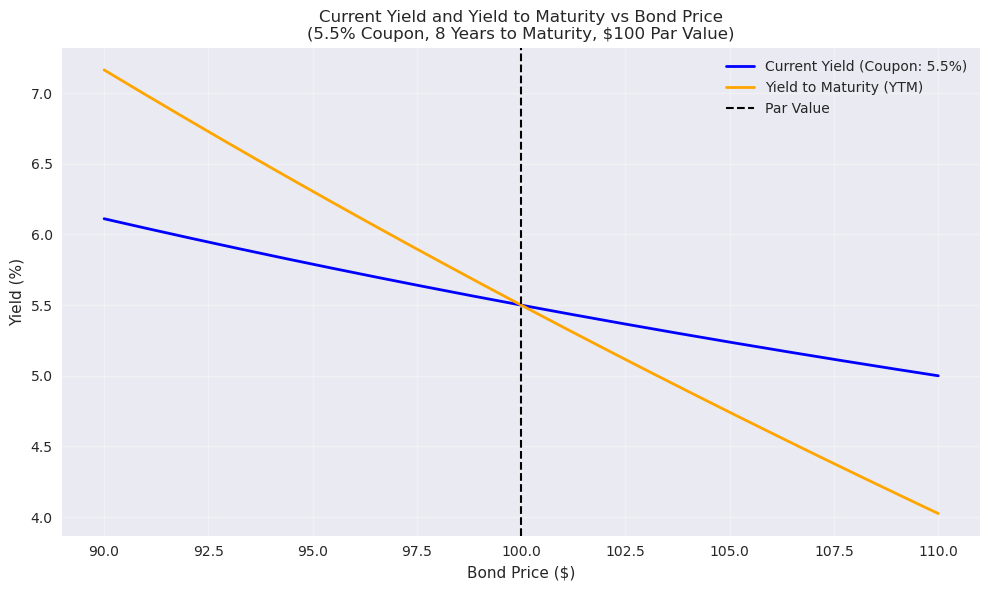

In [12]:
def calculate_current_yield(annual_coupon, current_price):
    """Calculate current yield"""
    return (annual_coupon / current_price) * 100

def bond_ytm_equation(ytm, coupon_rate, years_to_maturity, current_price, par_value=100, frequency=2):
    """
    Equation for YTM calculation - this should equal zero when YTM is correct
    """
    coupon_payment = (coupon_rate / 100) * par_value / frequency
    periods = years_to_maturity * frequency
    period_yield = ytm / frequency
    pv_coupons = sum([coupon_payment / (1 + period_yield)**t for t in range(1, periods + 1)])
    pv_principal = par_value / (1 + period_yield)**periods
    return pv_coupons + pv_principal - current_price

from scipy.optimize import newton

def calculate_ytm_newton_raphson(coupon_rate, years_to_maturity, current_price, par_value=100, frequency=2, initial_guess=0.05):
    """
    Calculate YTM using Newton-Raphson method
    """
    try:
        ytm = newton(lambda y: bond_ytm_equation(y, coupon_rate, years_to_maturity, current_price, par_value, frequency), 
                    initial_guess, maxiter=100)
        return ytm * 100  # Convert to percentage
    except:
        return None

# Parameters for the bond
par_value = 100
years_to_maturity = 8
coupon_rate = 5.5

annual_coupon = (coupon_rate / 100) * par_value

# Generate price range around par for plotting
prices = np.linspace(90, 110, 200)

# Calculate current yield for each price
current_yields = [calculate_current_yield(annual_coupon, p) for p in prices]

# Calculate YTM for each price
ytms = [calculate_ytm_newton_raphson(coupon_rate, years_to_maturity, p, par_value) for p in prices]

plt.figure(figsize=(10, 6))
plt.plot(prices, current_yields, label=f'Current Yield (Coupon: {coupon_rate}%)', color='blue', linewidth=2)
plt.plot(prices, ytms, label='Yield to Maturity (YTM)', color='orange', linewidth=2)
plt.axvline(x=par_value, color='black', linestyle='--', linewidth=1.5, label='Par Value')
plt.xlabel('Bond Price ($)')
plt.ylabel('Yield (%)')
plt.title('Current Yield and Yield to Maturity vs Bond Price\n(5.5% Coupon, 8 Years to Maturity, $100 Par Value)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

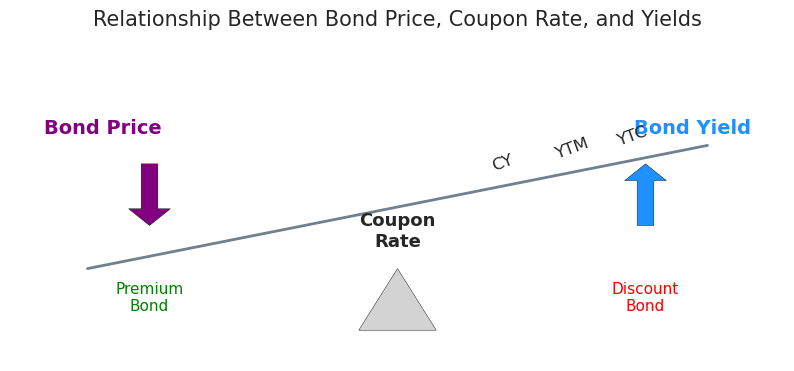

In [13]:
# Visualize the relationship between bond price, coupon rate, current yield, and YTM
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 4))

# Draw the seesaw (line)
ax.plot([0.1, 0.9], [0.5, 0.7], color='slategray', linewidth=2)

# Draw the fulcrum (triangle)
triangle = patches.Polygon([[0.5, 0.5], [0.45, 0.4], [0.55, 0.4]], closed=True, color='lightgray', ec='black', zorder=3)
ax.add_patch(triangle)

# Add coupon rate label at fulcrum
ax.text(0.5, 0.53, 'Coupon\nRate', ha='center', va='bottom', fontsize=13, fontweight='bold')

# Add left (Bond Price) arrow and label
ax.annotate('', xy=(0.18, 0.57), xytext=(0.18, 0.67), arrowprops=dict(facecolor='purple', width=12, headwidth=30), zorder=4)
ax.text(0.12, 0.72, 'Bond Price', color='purple', fontsize=14, fontweight='bold', ha='center')

# Add right (Bond Yield) arrow and label
ax.annotate('', xy=(0.82, 0.67), xytext=(0.82, 0.57), arrowprops=dict(facecolor='dodgerblue', width=12, headwidth=30), zorder=4)
ax.text(0.88, 0.72, 'Bond Yield', color='dodgerblue', fontsize=14, fontweight='bold', ha='center')

# Add yield labels along the seesaw
ax.text(0.62, 0.66, 'CY', fontsize=12, rotation=20)
ax.text(0.7, 0.68, 'YTM', fontsize=12, rotation=20)
ax.text(0.78, 0.70, 'YTC', fontsize=12, rotation=20)

# Add premium/discount annotations
ax.text(0.18, 0.48, 'Premium\nBond', ha='center', va='top', fontsize=11, color='green')
ax.text(0.82, 0.48, 'Discount\nBond', ha='center', va='top', fontsize=11, color='red')

# Hide axes
ax.axis('off')
ax.set_xlim(0, 1)
ax.set_ylim(0.35, 0.85)
plt.title('Relationship Between Bond Price, Coupon Rate, and Yields', fontsize=15, pad=20)
plt.show()

### 2.2 Newton-Raphson Method for YTM Calculation

The Newton-Raphson method is an iterative numerical technique used to find the roots of equations. For YTM calculation, we need to solve for the yield that makes the present value of all bond cash flows equal to the current market price.

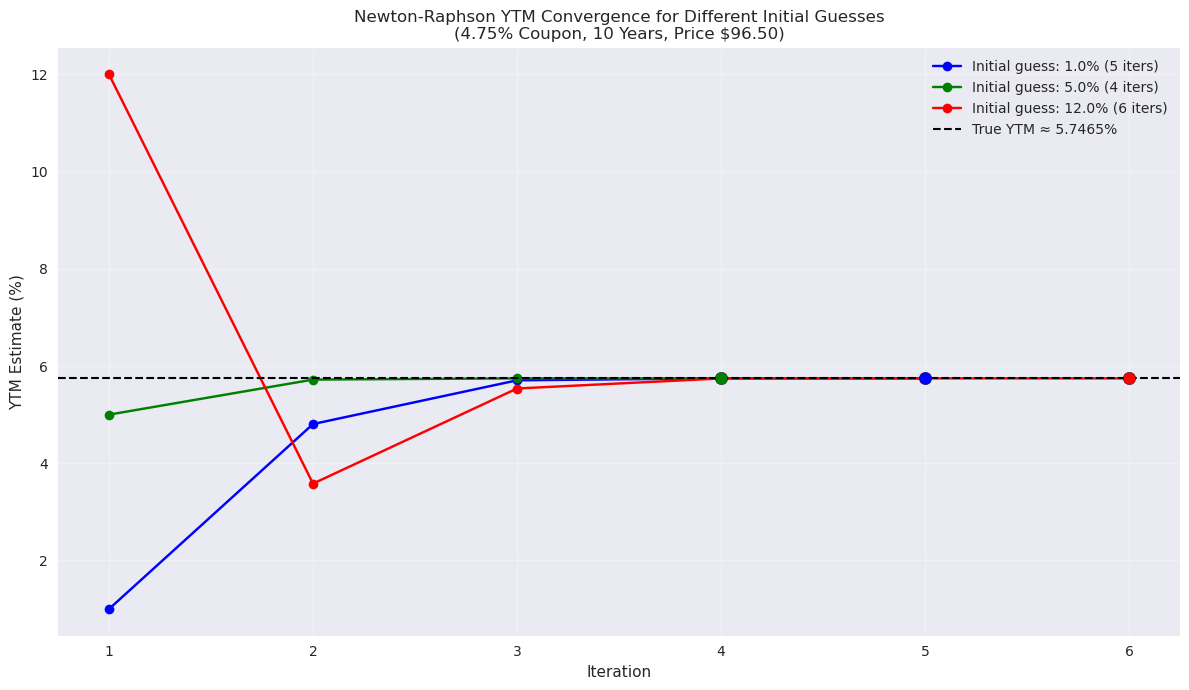

Newton-Raphson Method for YTM Calculation (Multiple Initial Guesses)
Bond: 4.75% coupon, 10 years to maturity, trading at $92.5
----------------------------------------------------------------------
Initial guess: 1.00% | Final YTM: 5.7465% | Iterations: 5
Initial guess: 5.00% | Final YTM: 5.7465% | Iterations: 4
Initial guess: 12.00% | Final YTM: 5.7465% | Iterations: 6


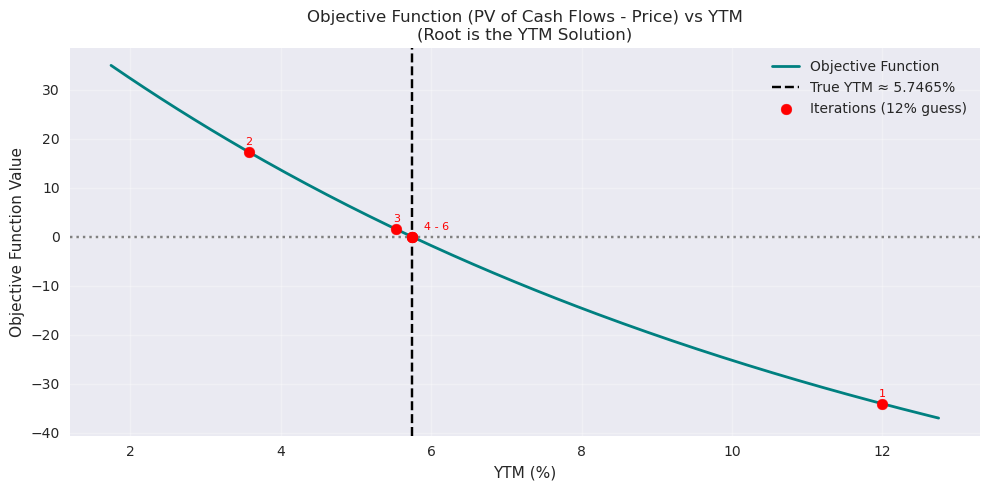

In [6]:
def ytm_newton_raphson_detailed(coupon_rate, years_to_maturity, current_price, par_value=100, frequency=2, 
                               initial_guess=0.05, tolerance=1e-6, max_iterations=100):
    """
    Detailed Newton-Raphson implementation for YTM with step-by-step tracking
    """
    def f(ytm):
        """Function to find root of (should equal zero)"""
        return bond_ytm_equation(ytm, coupon_rate, years_to_maturity, current_price, par_value, frequency)
    
    def f_prime(ytm, h=1e-8):
        """Numerical derivative"""
        return (f(ytm + h) - f(ytm)) / h
    
    ytm = initial_guess
    iterations = []
    
    for i in range(max_iterations):
        f_val = f(ytm)
        f_prime_val = f_prime(ytm)
        
        iterations.append({
            'iteration': i + 1,
            'ytm': ytm * 100,
            'f_value': f_val,
            'derivative': f_prime_val
        })
        
        if abs(f_val) < tolerance:
            break
            
        if abs(f_prime_val) < 1e-12:
            print("Warning: Derivative too small, may not converge")
            break
            
        ytm_new = ytm - f_val / f_prime_val
        ytm = ytm_new
    
    return ytm * 100, iterations

# Demonstrate Newton-Raphson for YTM calculation with multiple initial guesses
coupon_rate = 4.75
years_to_maturity = 10
current_price = 92.50
par_value = 100

# First, estimate the 'true' YTM using a reasonable guess
true_ytm, _ = ytm_newton_raphson_detailed(
    coupon_rate=coupon_rate,
    years_to_maturity=years_to_maturity,
    current_price=current_price,
    par_value=par_value,
    initial_guess=0.05
)

initial_guesses = [0.01, 0.05, 0.12]  # Below, near, and above the true YTM
colors = ['blue', 'green', 'red']
labels = [f"Initial guess: {g*100:.1f}%" for g in initial_guesses]

plt.figure(figsize=(12, 7))

for idx, (guess, color, label) in enumerate(zip(initial_guesses, colors, labels)):
    ytm_result, iterations = ytm_newton_raphson_detailed(
        coupon_rate=coupon_rate,
        years_to_maturity=years_to_maturity,
        current_price=current_price,
        par_value=par_value,
        initial_guess=guess
    )
    ytm_values = [it['ytm'] for it in iterations]
    plt.plot(range(1, len(ytm_values) + 1), ytm_values, marker='o', color=color, label=f"{label} ({len(ytm_values)} iters)")
    # Annotate final point
    plt.scatter([len(ytm_values)], [ytm_values[-1]], color=color, s=80, edgecolor='black', zorder=5)
#    plt.text(len(ytm_values)+0.1, ytm_values[-1], f"{ytm_values[-1]:.4f}%", color=color, fontsize=9, va='center')

plt.axhline(y=true_ytm, color='black', linestyle='--', linewidth=1.5, label=f"True YTM ≈ {true_ytm:.4f}%")
plt.xlabel('Iteration')
plt.ylabel('YTM Estimate (%)')
plt.title('Newton-Raphson YTM Convergence for Different Initial Guesses\n(4.75% Coupon, 10 Years, Price $96.50)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Newton-Raphson Method for YTM Calculation (Multiple Initial Guesses)")
print(f"Bond: {coupon_rate}% coupon, {years_to_maturity} years to maturity, trading at ${current_price}")
print("-" * 70)
for idx, guess in enumerate(initial_guesses):
    ytm_result, iterations = ytm_newton_raphson_detailed(
        coupon_rate=coupon_rate,
        years_to_maturity=years_to_maturity,
        current_price=current_price,
        par_value=par_value,
        initial_guess=guess
    )
    print(f"Initial guess: {guess*100:.2f}% | Final YTM: {ytm_result:.4f}% | Iterations: {len(iterations)}")

# --- New plot: Objective function vs YTM ---
# Use the same bond parameters as above

def ytm_objective(ytm, coupon_rate, years_to_maturity, current_price, par_value=100, frequency=2):
    return bond_ytm_equation(ytm, coupon_rate, years_to_maturity, current_price, par_value, frequency)

# Range of YTM values around the true YTM (in decimal, not percent)
ytms_range = np.linspace(true_ytm/100 - 0.04, true_ytm/100 + 0.07, 200)
objective_values = [ytm_objective(y, coupon_rate, years_to_maturity, current_price, par_value) for y in ytms_range]

plt.figure(figsize=(10, 5))
plt.plot(ytms_range * 100, objective_values, color='teal', linewidth=2, label='Objective Function')
plt.axvline(x=true_ytm, color='black', linestyle='--', label=f'True YTM ≈ {true_ytm:.4f}%')
plt.axhline(y=0, color='gray', linestyle=':')

# Add points for each iteration of the 12% initial guess scenario
initial_guess_12 = 0.12
ytm_result_12, iterations_12 = ytm_newton_raphson_detailed(
    coupon_rate=coupon_rate,
    years_to_maturity=years_to_maturity,
    current_price=current_price,
    par_value=par_value,
    initial_guess=initial_guess_12
)
iter_ytms = [it['ytm']/100 for it in iterations_12]
iter_obj = [ytm_objective(y, coupon_rate, years_to_maturity, current_price, par_value) for y in iter_ytms]
plt.scatter([y*100 for y in iter_ytms], iter_obj, color='red', s=60, zorder=5, label='Iterations (12% guess)')
for i, (x, y) in enumerate(zip([y*100 for y in iter_ytms], iter_obj)):
    if i < 3:
        plt.text(x, y+1, str(i+1), color='red', fontsize=8, ha='center', va='bottom')
    elif i == len(iter_ytms) - 1:
        plt.text(x+0.5, y+1, f"4 - {i+1}", color='red', fontsize=8, ha='right', va='bottom')

plt.xlabel('YTM (%)')
plt.ylabel('Objective Function Value')
plt.title('Objective Function (PV of Cash Flows - Price) vs YTM\n(Root is the YTM Solution)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### 2.3 Bond Yield Evolution: Premium, Discount, and Par Bonds

Let's examine how bond yields evolve as bonds approach maturity for different initial price scenarios.

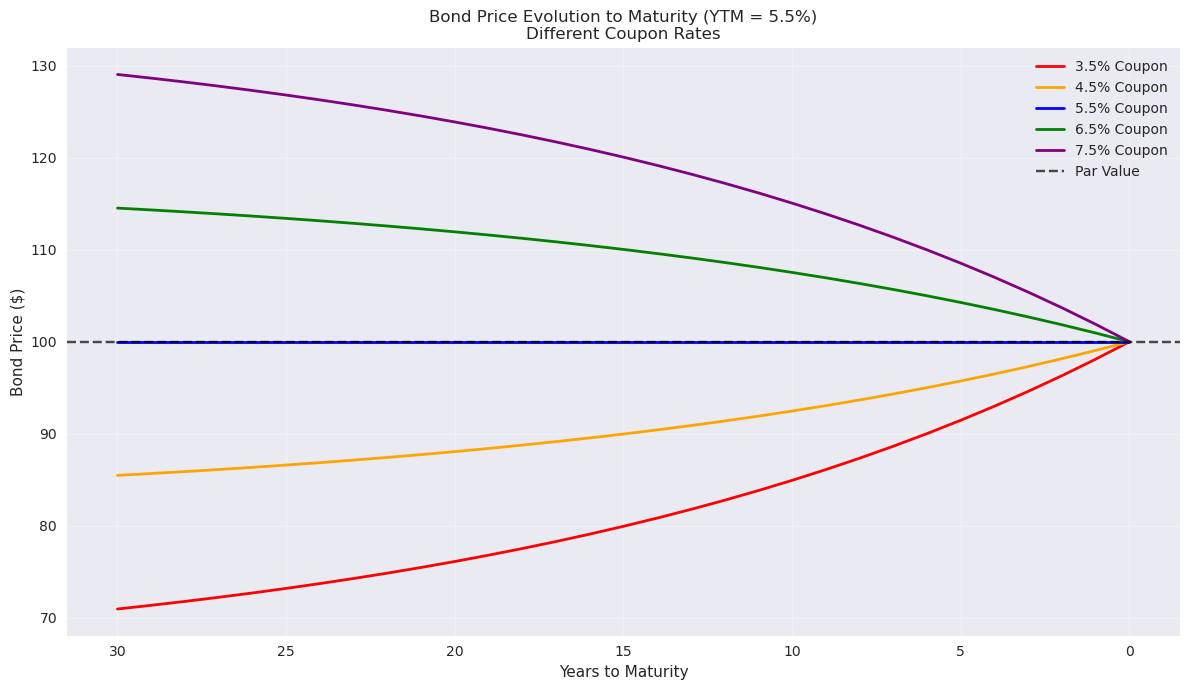


Bond Scenarios Summary:
Coupon Rate	Initial Price (30Y)	At Maturity
---------------------------------------------
3.5%		$70.93		$100.00
4.5%		$85.47		$100.00
5.5%		$100.00		$100.00
6.5%		$114.53		$100.00
7.5%		$129.07		$100.00


In [24]:
def bond_price(coupon_rate, yield_rate, years, par=100):
    """Calculate bond price using present value formula"""
    coupon = coupon_rate * par / 100
    pv_coupons = sum([coupon / (1 + yield_rate/100)**t for t in range(1, int(years)+1)])
    pv_principal = par / (1 + yield_rate/100)**years
    return pv_coupons + pv_principal

# Parameters
par = 100
ytmm = 5.5  # YTM for all bonds
coupon_rates = [3.5, 4.5, 5.5, 6.5, 7.5]
colors = ['red', 'orange', 'blue', 'green', 'purple']
labels = [f"{cr:.1f}% Coupon" for cr in coupon_rates]

# Years to maturity: 30 to 0 in 1-year increments
years_to_maturity = np.arange(30, -1, -1)

plt.figure(figsize=(12, 7))

for cr, color, label in zip(coupon_rates, colors, labels):
    prices = [bond_price(cr, ytmm, n, par) for n in years_to_maturity if n > 0]
    # Add par value at maturity (n=0)
    prices.append(par)
    plt.plot(years_to_maturity, prices, color=color, label=label, linewidth=2)

plt.axhline(y=par, color='black', linestyle='--', alpha=0.7, label='Par Value')
plt.xlabel('Years to Maturity')
plt.ylabel('Bond Price ($)')
plt.title('Bond Price Evolution to Maturity (YTM = 5.5%)\nDifferent Coupon Rates')
plt.xticks(np.arange(0, 31, 5))
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()  # Reverse the x-axis direction
plt.tight_layout()
plt.show()

# Summary table
print("\nBond Scenarios Summary:")
print("Coupon Rate\tInitial Price (30Y)\tAt Maturity")
print("-" * 45)
for cr in coupon_rates:
    initial_price = bond_price(cr, ytmm, 30, par)
    print(f"{cr:.1f}%\t\t${initial_price:.2f}\t\t${par:.2f}")

## 3. Total Return Calculation for Bonds

Total return measures the complete return from holding a bond over a specific period, including both income and capital appreciation/depreciation.

### 3.1 Components of Bond Return

Bond total return consists of three main components:

1. **Coupon Income**: Interest payments received during the holding period
2. **Capital Gain/Loss**: Change in bond price from purchase to sale
3. **Reinvestment Income**: Return from reinvesting coupon payments (if applicable)

**Formula**: Total Return = (Coupon Income + Capital Gain/Loss + Reinvestment Income) / Initial Investment

Bond Total Return Analysis
Bond: 5.5% coupon, purchased at $980
Reinvestment rate: 4.0%

1 Year Hold - Sale Price: $985
  Coupon Income: $55.00
  Capital Gain/Loss: $5.00
  Reinvestment Income: $0.55
  Total Dollar Return: $60.55
  Total Return: 6.18%
  Annualized Return: 6.18%

3 Year Hold - Sale Price: $995
  Coupon Income: $165.00
  Capital Gain/Loss: $15.00
  Reinvestment Income: $8.47
  Total Dollar Return: $188.47
  Total Return: 19.23%
  Annualized Return: 6.04%

5 Year Hold (to maturity) - Sale Price: $1000
  Coupon Income: $275.00
  Capital Gain/Loss: $20.00
  Reinvestment Income: $26.12
  Total Dollar Return: $321.12
  Total Return: 32.77%
  Annualized Return: 5.83%

2 Year Hold (price decline) - Sale Price: $975
  Coupon Income: $110.00
  Capital Gain/Loss: $-5.00
  Reinvestment Income: $3.34
  Total Dollar Return: $108.34
  Total Return: 11.06%
  Annualized Return: 5.38%


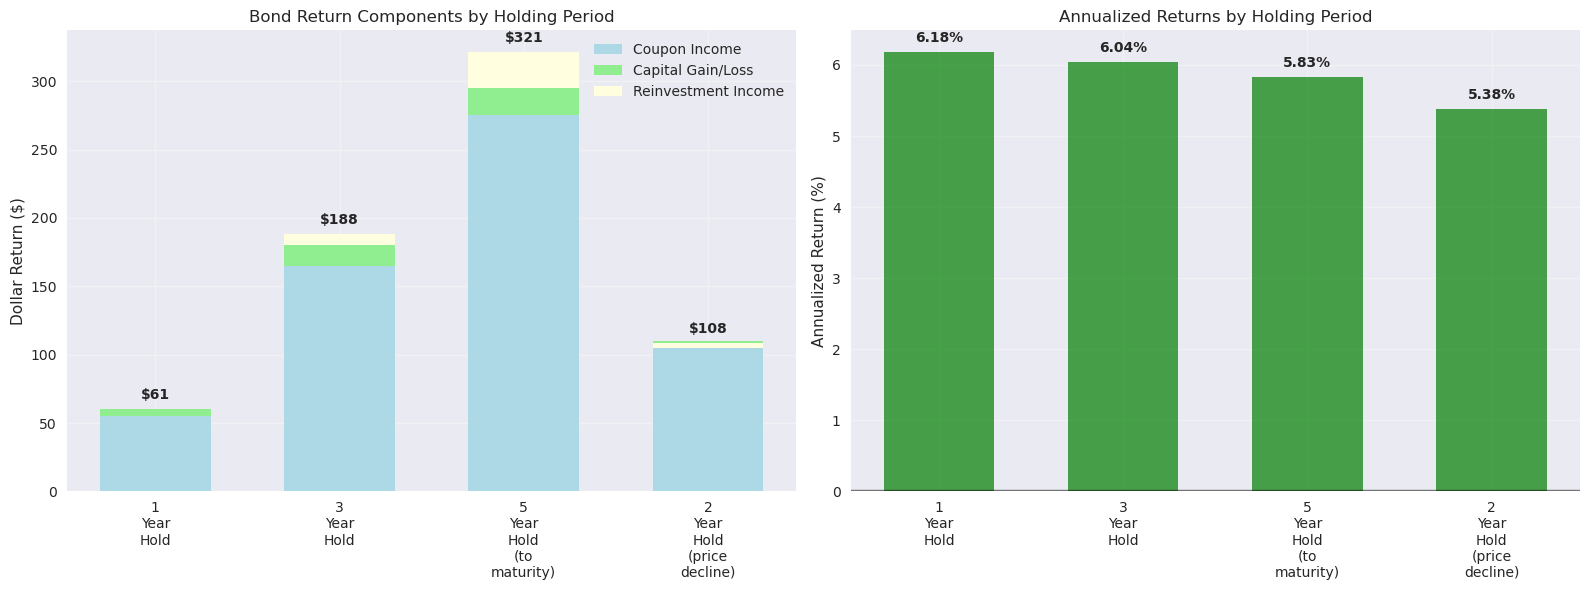

In [25]:
def calculate_bond_total_return(purchase_price, sale_price, coupon_rate, par_value, 
                               holding_period_years, reinvestment_rate=None, frequency=2):
    """
    Calculate total return for a bond held over a specific period
    
    Parameters:
    purchase_price: price paid for bond
    sale_price: price received when sold
    coupon_rate: annual coupon rate (as percentage)
    par_value: face value of bond
    holding_period_years: years bond was held
    reinvestment_rate: rate at which coupons are reinvested (if None, assumes no reinvestment)
    frequency: coupon payments per year
    """
    
    # Calculate coupon income
    annual_coupon = (coupon_rate / 100) * par_value
    total_coupon_payments = annual_coupon * holding_period_years
    
    # Calculate capital gain/loss
    capital_gain_loss = sale_price - purchase_price
    
    # Calculate reinvestment income (if applicable)
    reinvestment_income = 0
    if reinvestment_rate is not None:
        coupon_per_period = annual_coupon / frequency
        periods = int(holding_period_years * frequency)
        period_reinvestment_rate = reinvestment_rate / frequency
        
        # Future value of reinvested coupons
        fv_coupons = 0
        for period in range(periods):
            periods_remaining = periods - period - 1
            fv_coupons += coupon_per_period * (1 + period_reinvestment_rate) ** periods_remaining
        
        reinvestment_income = fv_coupons - total_coupon_payments
    
    # Total return components
    total_dollar_return = total_coupon_payments + capital_gain_loss + reinvestment_income
    total_return_percentage = (total_dollar_return / purchase_price) * 100
    
    # Annualized return
    annualized_return = ((1 + total_return_percentage/100) ** (1/holding_period_years) - 1) * 100
    
    return {
        'coupon_income': total_coupon_payments,
        'capital_gain_loss': capital_gain_loss,
        'reinvestment_income': reinvestment_income,
        'total_dollar_return': total_dollar_return,
        'total_return_pct': total_return_percentage,
        'annualized_return': annualized_return
    }

# Example: Bond held for different periods
bond_data = {
    'coupon_rate': 5.5,
    'par_value': 1000,
    'purchase_price': 980,
    'reinvestment_rate': 0.04  # 4% reinvestment rate
}

# Different holding periods and sale prices
scenarios = [
    {'period': 1, 'sale_price': 985, 'description': '1 Year Hold'},
    {'period': 3, 'sale_price': 995, 'description': '3 Year Hold'},
    {'period': 5, 'sale_price': 1000, 'description': '5 Year Hold (to maturity)'},
    {'period': 2, 'sale_price': 975, 'description': '2 Year Hold (price decline)'}
]

print("Bond Total Return Analysis")
print(f"Bond: {bond_data['coupon_rate']}% coupon, purchased at ${bond_data['purchase_price']}")
print(f"Reinvestment rate: {bond_data['reinvestment_rate']*100}%")
print("=" * 80)

results = []
for scenario in scenarios:
    result = calculate_bond_total_return(
        bond_data['purchase_price'],
        scenario['sale_price'],
        bond_data['coupon_rate'],
        bond_data['par_value'],
        scenario['period'],
        bond_data['reinvestment_rate']
    )
    result['description'] = scenario['description']
    result['period'] = scenario['period']
    result['sale_price'] = scenario['sale_price']
    results.append(result)
    
    print(f"\n{scenario['description']} - Sale Price: ${scenario['sale_price']}")
    print(f"  Coupon Income: ${result['coupon_income']:.2f}")
    print(f"  Capital Gain/Loss: ${result['capital_gain_loss']:.2f}")
    print(f"  Reinvestment Income: ${result['reinvestment_income']:.2f}")
    print(f"  Total Dollar Return: ${result['total_dollar_return']:.2f}")
    print(f"  Total Return: {result['total_return_pct']:.2f}%")
    print(f"  Annualized Return: {result['annualized_return']:.2f}%")

# Create visualization of return components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart of return components
descriptions = [r['description'] for r in results]
coupon_income = [r['coupon_income'] for r in results]
capital_gains = [r['capital_gain_loss'] for r in results]
reinvestment = [r['reinvestment_income'] for r in results]

x = np.arange(len(descriptions))
width = 0.6

p1 = ax1.bar(x, coupon_income, width, label='Coupon Income', color='lightblue')
p2 = ax1.bar(x, capital_gains, width, bottom=coupon_income, label='Capital Gain/Loss', color='lightgreen')
p3 = ax1.bar(x, reinvestment, width, bottom=np.array(coupon_income) + np.array(capital_gains), 
            label='Reinvestment Income', color='lightyellow')

ax1.set_ylabel('Dollar Return ($)')
ax1.set_title('Bond Return Components by Holding Period')
ax1.set_xticks(x)
ax1.set_xticklabels([d.replace(' ', '\n') for d in descriptions])
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels
for i, (c, g, r) in enumerate(zip(coupon_income, capital_gains, reinvestment)):
    total = c + g + r
    ax1.text(i, total + 5, f'${total:.0f}', ha='center', va='bottom', fontweight='bold')

# Annualized returns comparison
annualized_returns = [r['annualized_return'] for r in results]
colors = ['green' if ret > 0 else 'red' for ret in annualized_returns]

bars = ax2.bar(x, annualized_returns, width, color=colors, alpha=0.7)
ax2.set_ylabel('Annualized Return (%)')
ax2.set_title('Annualized Returns by Holding Period')
ax2.set_xticks(x)
ax2.set_xticklabels([d.replace(' ', '\n') for d in descriptions])
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add percentage labels
for bar, ret in zip(bars, annualized_returns):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.3),
             f'{ret:.2f}%', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

### 3.2 Impact of Holding Period on Total Return

Let's examine how holding period affects total return for bonds with different characteristics.

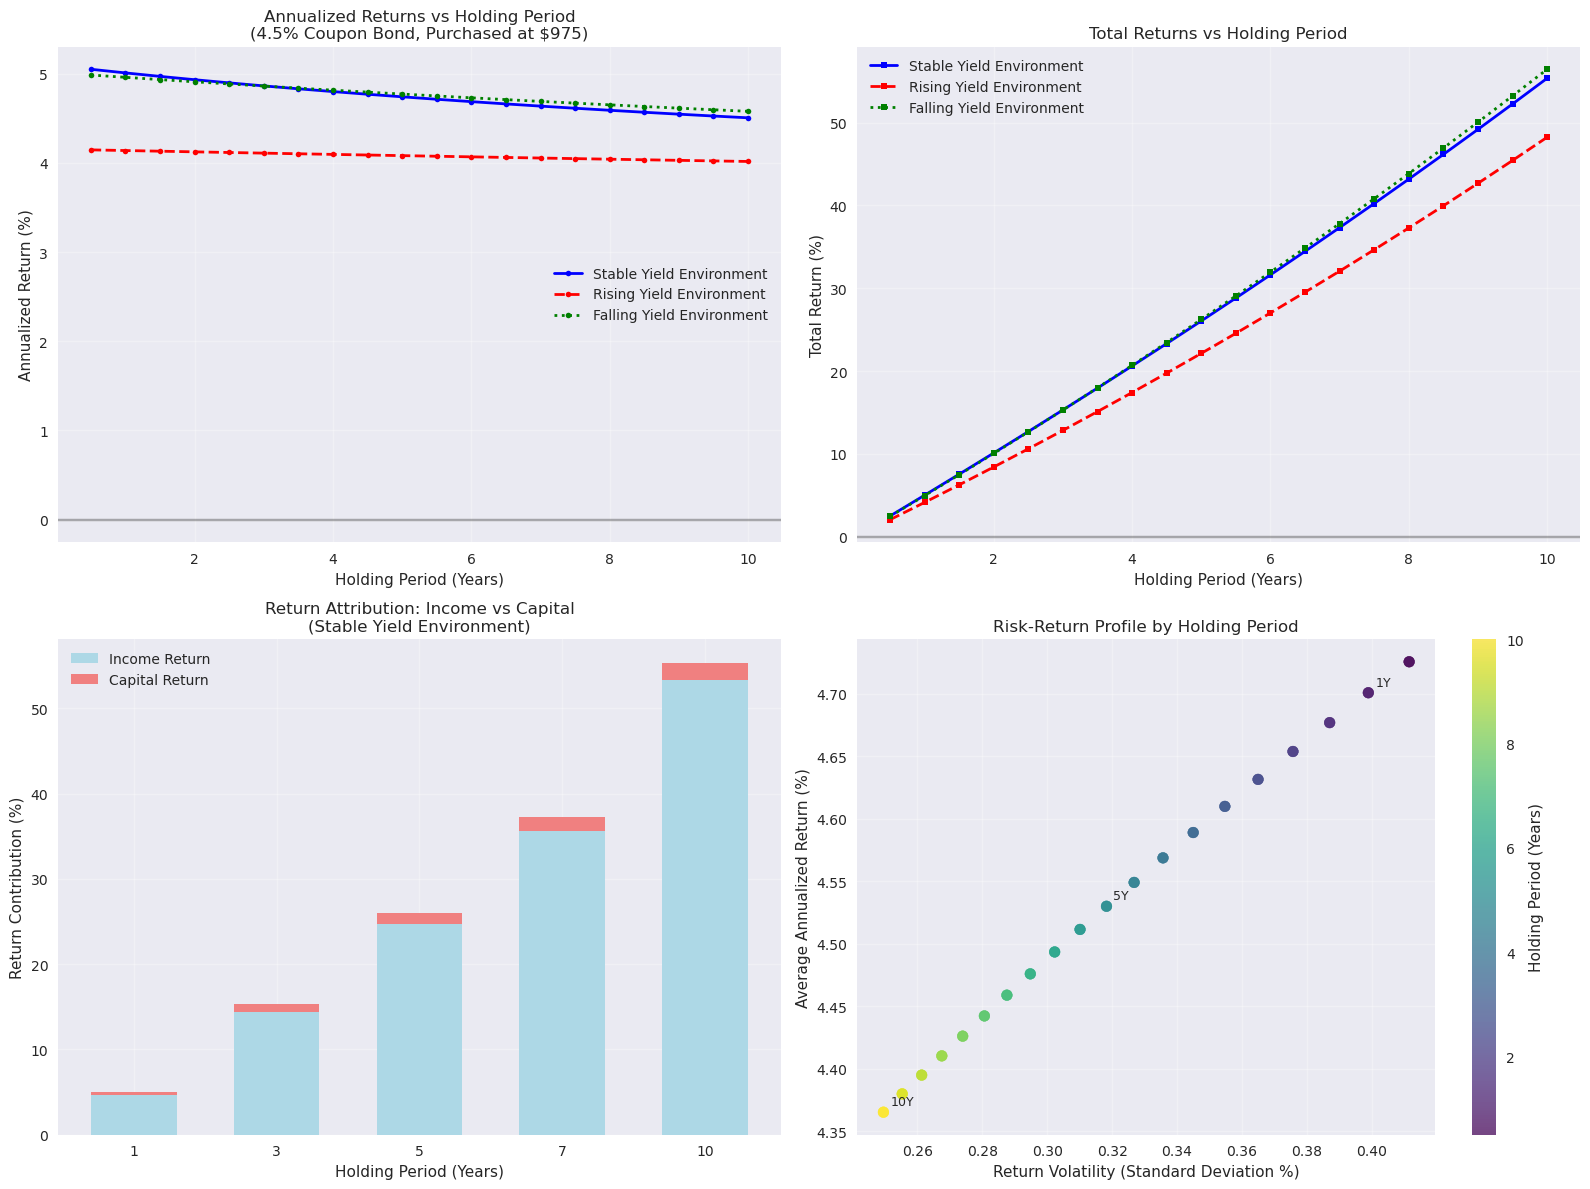

Key Observations:
1. Longer holding periods generally reduce the impact of short-term price volatility
2. In stable yield environments, returns converge toward the yield to maturity
3. Income return (coupons) becomes more significant with longer holding periods
4. The risk-return profile varies significantly with holding period and market conditions


In [26]:
def analyze_holding_period_impact(coupon_rate, purchase_price, par_value=1000, max_years=10):
    """
    Analyze how total return changes with different holding periods
    """
    holding_periods = np.arange(0.5, max_years + 0.5, 0.5)
    
    # Assume different sale price scenarios
    scenarios = {
        'Stable Yield Environment': lambda years: par_value + (purchase_price - par_value) * np.exp(-0.15 * years),
        'Rising Yield Environment': lambda years: purchase_price - 5 * years,  # Price declines over time
        'Falling Yield Environment': lambda years: purchase_price + 3 * years   # Price increases over time
    }
    
    results = {}
    
    for scenario_name, price_function in scenarios.items():
        annualized_returns = []
        total_returns = []
        
        for period in holding_periods:
            sale_price = max(price_function(period), par_value * 0.7)  # Floor at 70% of par
            sale_price = min(sale_price, par_value * 1.3)  # Ceiling at 130% of par
            
            result = calculate_bond_total_return(
                purchase_price, sale_price, coupon_rate, par_value, period, 0.03
            )
            
            annualized_returns.append(result['annualized_return'])
            total_returns.append(result['total_return_pct'])
        
        results[scenario_name] = {
            'annualized_returns': annualized_returns,
            'total_returns': total_returns
        }
    
    return holding_periods, results

# Analyze for a typical bond
periods, analysis_results = analyze_holding_period_impact(
    coupon_rate=4.5,
    purchase_price=975,
    par_value=1000
)

# Create comprehensive visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

colors = ['blue', 'red', 'green']
linestyles = ['-', '--', ':']

# Annualized returns by holding period
for i, (scenario_name, data) in enumerate(analysis_results.items()):
    ax1.plot(periods, data['annualized_returns'], 
             color=colors[i], linestyle=linestyles[i], linewidth=2, 
             label=scenario_name, marker='o', markersize=4)

ax1.set_xlabel('Holding Period (Years)')
ax1.set_ylabel('Annualized Return (%)')
ax1.set_title('Annualized Returns vs Holding Period\n(4.5% Coupon Bond, Purchased at $975)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Total returns by holding period
for i, (scenario_name, data) in enumerate(analysis_results.items()):
    ax2.plot(periods, data['total_returns'], 
             color=colors[i], linestyle=linestyles[i], linewidth=2, 
             label=scenario_name, marker='s', markersize=4)

ax2.set_xlabel('Holding Period (Years)')
ax2.set_ylabel('Total Return (%)')
ax2.set_title('Total Returns vs Holding Period')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Return attribution analysis for stable environment
stable_periods = [1, 3, 5, 7, 10]
coupon_contributions = []
capital_contributions = []

for period in stable_periods:
    # Simulate stable environment
    sale_price = 1000 + (975 - 1000) * np.exp(-0.15 * period)
    result = calculate_bond_total_return(975, sale_price, 4.5, 1000, period, 0.03)
    
    total_return = result['total_dollar_return']
    coupon_pct = (result['coupon_income'] + result['reinvestment_income']) / 975 * 100
    capital_pct = result['capital_gain_loss'] / 975 * 100
    
    coupon_contributions.append(coupon_pct)
    capital_contributions.append(capital_pct)

x = np.arange(len(stable_periods))
width = 0.6

p1 = ax3.bar(x, coupon_contributions, width, label='Income Return', color='lightblue')
p2 = ax3.bar(x, capital_contributions, width, bottom=coupon_contributions, 
            label='Capital Return', color='lightcoral')

ax3.set_ylabel('Return Contribution (%)')
ax3.set_xlabel('Holding Period (Years)')
ax3.set_title('Return Attribution: Income vs Capital\n(Stable Yield Environment)')
ax3.set_xticks(x)
ax3.set_xticklabels(stable_periods)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Risk-return profile
# Calculate volatility of returns across scenarios for each period
return_volatilities = []
average_returns = []

for i, period in enumerate(periods):
    period_returns = [data['annualized_returns'][i] for data in analysis_results.values()]
    return_volatilities.append(np.std(period_returns))
    average_returns.append(np.mean(period_returns))

ax4.scatter(return_volatilities, average_returns, c=periods, cmap='viridis', s=60, alpha=0.7)
cbar = plt.colorbar(ax4.scatter(return_volatilities, average_returns, c=periods, cmap='viridis', s=60, alpha=0.7), ax=ax4)
cbar.set_label('Holding Period (Years)')
ax4.set_xlabel('Return Volatility (Standard Deviation %)')
ax4.set_ylabel('Average Annualized Return (%)')
ax4.set_title('Risk-Return Profile by Holding Period')
ax4.grid(True, alpha=0.3)

# Add annotations for specific periods
for i, period in enumerate([1, 5, 10]):
    if period in periods:
        idx = list(periods).index(period)
        ax4.annotate(f'{period}Y', 
                    (return_volatilities[idx], average_returns[idx]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

print("Key Observations:")
print("1. Longer holding periods generally reduce the impact of short-term price volatility")
print("2. In stable yield environments, returns converge toward the yield to maturity")
print("3. Income return (coupons) becomes more significant with longer holding periods")
print("4. The risk-return profile varies significantly with holding period and market conditions")

## Summary

This notebook has covered the essential aspects of bond mechanics and yield analysis:

### Key Takeaways:

1. **Pricing Conventions**: U.S. Treasury bonds use unique 1/32s pricing, and understanding clean vs. dirty prices is crucial for accurate analysis.

2. **Yield Measures**: Different yield measures serve different purposes:
   - Nominal yield provides the fixed rate
   - Current yield shows income relative to current price
   - YTM provides total return if held to maturity

3. **Newton-Raphson Method**: An efficient numerical technique for calculating YTM when analytical solutions are impractical.

4. **Total Return Analysis**: Understanding all components (coupon income, capital gains/losses, reinvestment income) is essential for comprehensive bond evaluation.

5. **Holding Period Impact**: The relationship between holding period, market conditions, and total return is complex and requires careful analysis.

### Practical Applications:

- Portfolio managers use these concepts for bond selection and risk management
- Individual investors can better understand bond behavior in different market environments
- Risk managers utilize these tools for duration and convexity analysis
- Traders apply these principles for identifying arbitrage opportunities

Understanding these bond mechanics provides the foundation for more advanced fixed income analysis, including duration, convexity, and complex derivative instruments.